# DUSVGD GMM


## Settings


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, SGD, RMSprop
from torch.distributions import Normal, Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily

import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=1000)
sns.set(style="white")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=True)

seed = 42
set_seed(seed)

print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type("torch.cuda.FloatTensor" if torch.cuda.is_available() else "torch.FloatTensor")
print("device =", device)


True
device = cuda


## Gaussian Mixture Model

$$p(x) = a_1\mathcal{N}(\mu_1,\sigma_1^2) + a_2\mathcal{N}(\mu_2,\sigma_2^2)$$


In [2]:
class GMM:
    def __init__(self):
        self.weights = torch.tensor([0.75, 0.25])
        self.means = torch.tensor([-2.0, 2.5])
        self.stds = torch.tensor([1.0, 1.0])

    def model(self):
        mix = Categorical(self.weights)
        comp = Normal(self.means, self.stds)
        return MixtureSameFamily(mix, comp)

    def print_parameters(self):
        print('Target Distribution (GMM): weights =', self.weights.tolist(), 
              ', means =', self.means.tolist(), ', stds =', self.stds.tolist())

model_gmm = GMM()
target_model = model_gmm.model()

## Hyper parameters


In [3]:
# Hyperparameters for SVGD and C-DUSVGD
num_particles = 100         # Number of particles in SVGD
data_size = 1000            # Total number of data points
train_batch_size = 50       # Batch size for training
test_batch_size = 100       # Batch size for testing
num_epochs = 10             # Number of epochs for DUSVGD training
num_epochs_c = 40           # Number of epochs for C-DUSVGD training
max_du_iterations = 10      # Number of iterations for dual updates in DUSVGD
lr_adam = 0.005             # Learning rate for Adam optimizer in DUSVGD
lr_adam_c = 0.0005          # Learning rate for Adam optimizer in C-DUSVGD
init_params = 2.0           # Initial value for SVGD learning rate
init_params_c = torch.tensor([0.3, 1.0])  # Initial parameters for C-DUSVGD
init_dist_mean = -2.0       # Mean of the initial distribution for particles
init_dist_std = 1.0         # Standard deviation of the initial distribution for particles

def print_hyperparameters():
    print('num_particles:\t', num_particles)
    print('data_size:\t', data_size)
    print('train_batch_size:\t', train_batch_size)
    print('test_batch_size:\t', test_batch_size)
    print('num_epochs:\t', num_epochs)
    print('num_epochs_c:\t', num_epochs_c)
    print('max_du_iterations:\t', max_du_iterations)
    print('lr_adam:\t', lr_adam)
    print('lr_adam_c:\t', lr_adam_c)
    print('init_params:\t', init_params)
    print('init_params_c:\t', init_params_c.tolist())
    print('init_distribution (Normal): mean =', init_dist_mean, ', std =', init_dist_std)
    model_gmm.print_parameters()

print_hyperparameters()

num_particles:	 100
data_size:	 1000
train_batch_size:	 50
test_batch_size:	 50
num_epochs:	 10
num_epochs_c:	 40
max_du_iterations:	 10
lr_adam:	 0.005
lr_adam_c:	 0.0005
init_params:	 2.0
init_params_c:	 [0.30000001192092896, 1.0]
init_distribution (Normal): mean = -2.0 , std = 1.0
Target Distribution (GMM): weights = [0.75, 0.25] , means = [-2.0, 2.5] , stds = [1.0, 1.0]


## Generating Datasets


In [4]:
x_data = torch.normal(init_dist_mean, init_dist_std, size=(data_size, num_particles)).to(device)
t_data = target_model.sample([data_size, num_particles]).to(device)

train_size = int(0.9 * data_size)
test_size = data_size - train_size
x_train, x_test = torch.utils.data.random_split(x_data, [train_size, test_size], generator=torch.Generator(device))
t_train, t_test = torch.utils.data.random_split(t_data, [train_size, test_size], generator=torch.Generator(device))

class CustomDataset:
    def __init__(self, X, t):
        self.X = X
        self.t = t

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.t[index]

train_dataset = CustomDataset(x_train, t_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, generator=torch.Generator(device))

test_dataset = CustomDataset(x_test, t_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, generator=torch.Generator(device))


c:\Users\akmay\anaconda3\envs\py39\lib\site-packages\torch\distributions\categorical.py:118: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:75.)
  samples_2d = torch.multinomial(probs_2d, sample_shape.numel(), True).T


## SVGD


In [5]:
def median(tensor):
    tensor = tensor.clone().flatten(1)
    tensor_max = tensor.max(1).values.unsqueeze(1)
    median_val = (torch.cat((tensor, tensor_max), 1).median(1).values + tensor.median(1).values) / 2.0
    return median_val.view(-1, 1, 1)

def get_gradient(model_gmm, inputs, alpha, beta, retain_graph):
    inputs = inputs.clone().requires_grad_(True)
    bs, n, d = inputs.shape

    log_prob = model_gmm.model().log_prob(inputs)
    log_prob_grad = torch.autograd.grad(log_prob.sum(), inputs, retain_graph=retain_graph)[0]

    pairwise_distance = torch.cdist(inputs, inputs, p=2.0).pow(2).to(device)
    h = median(pairwise_distance) / math.log(n)
    kernel = torch.exp(-pairwise_distance / h)
    kernel_grad = 2 * (kernel.sum(2).diag_embed() - kernel).matmul(inputs) / h

    gradient = -(alpha * torch.matmul(kernel, log_prob_grad) + beta * kernel_grad) / n
    return gradient

# DUSVGD

In [6]:
class DUGD(nn.Module):
    def __init__(self, itr):
        super().__init__()
        self.gamma = nn.Parameter(init_params * torch.ones(itr))

    def forward(self, iteration, x_data):
        for i in range(iteration):
            j = i % max_du_iterations
            x_data = x_data - abs(self.gamma[j]) * get_gradient(model_gmm, x_data, 1.0, 1.0, retain_graph=True)
            x_data = torch.clamp(x_data, min=-15, max=15)

        return x_data, self.gamma

model_dugd = DUGD(max_du_iterations).to(device)
opt_dugd = optim.Adam(model_dugd.parameters(), lr=lr_adam)

# C-DUSVGD

In [7]:
def chebyshev_step(a, b, t, T):
    la1 = a ** 2
    lan = a ** 2 + b ** 2
    lr_c = 1 / ((la1 + lan) / 2 + ((lan - la1) / 2) * math.cos((2 * (T - t) - 1) * torch.pi / (2 * T)))
    return lr_c

class CDUGD(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(init_params_c)

    def forward(self, iteration, x_data):
        for i in range(iteration):
            lr_c = chebyshev_step(self.gamma[0], self.gamma[1], i, max_du_iterations)
            x_data = x_data - lr_c * get_gradient(model_gmm, x_data, 1.0, 1.0, retain_graph=True)
            x_data = torch.clamp(x_data, min=-15, max=15)

        return x_data, self.gamma

model_cdugd = CDUGD().to(device)
opt_cdugd = optim.Adam(model_cdugd.parameters(), lr=lr_adam_c)


## Training


In [8]:
class MMDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        x, y = outputs, targets
        bs, n, d = x.shape
        _, m, _ = y.shape
        sigma = 1

        xy = torch.cat([x.clone(), y.clone()], dim=1).to(device)
        dists = torch.cdist(xy, xy, p=2.0)
        k = torch.exp(-0.5 * dists**2) + torch.ones_like(dists) * 1e-5

        k_x = k[:, :n, :n]
        k_y = k[:, n:, n:]
        k_xy = k[:, :n, n:]
        mmd = (k_x.sum() / (n * (n - 1)) + k_y.sum() / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)) / bs
        return mmd

loss_func = MMDLoss()

def incremental_training():
    for iteration in range(max_du_iterations):
        print()
        for epoch in range(num_epochs):
            for batch in train_dataloader:
                torch.autograd.set_detect_anomaly(True)
                x, t = [tensor.unsqueeze(2).to(device) for tensor in batch]

                opt_dugd.zero_grad()
                x_hat, gamma = model_dugd(iteration + 1, x)
                loss = loss_func(x_hat, t)
                loss.backward()
                opt_dugd.step()

            print(f"\ri: {iteration + 1}\te: {epoch + 1}\tparams: {', '.join(f'{g:.2f}' for g in gamma.tolist())}\tloss: {loss.item():.3f}", end="    ")

def static_training():
    for epoch in range(num_epochs_c):
        for batch in train_dataloader:
            torch.autograd.set_detect_anomaly(True)
            x, t = [tensor.unsqueeze(2).to(device) for tensor in batch]

            opt_cdugd.zero_grad()
            x_hat, gamma = model_cdugd(max_du_iterations, x)
            loss = loss_func(x_hat, t)
            loss.backward()
            opt_cdugd.step()

        print(f"\re: {epoch + 1}\tparams: {', '.join(f'{g:.2f}' for g in gamma.tolist())}\tloss: {loss.item():.3f}", end="    ")
        if (epoch + 1) % 10 == 0:
            print()


In [9]:
incremental_training()

c:\Users\akmay\anaconda3\envs\py39\lib\site-packages\torch\functional.py:1222: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:156.)
  return _VF.cdist(x1, x2, p, None)  # type: ignore[attr-defined]
C:\Users\akmay\AppData\Local\Temp\ipykernel_18256\2346520049.py:4: UserWarning: median CUDA with indices output does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'

i: 1	e: 10	params: 1.93, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00	loss: 0.079    
i: 2	e: 10	params: 1.83, 3.38, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00	loss: 0.083    
i: 3	e: 10	params: 3.07, 5.07, 1.24, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00	loss: 0.070    
i: 4	e: 10	params: 3.56, 6.44, 1.18, 1.57, 2.00, 2.00, 2.00, 2.00, 2.00, 2.00	loss: 0.060    
i: 5	e: 10	params: 3.76, 7.56, 1.05, 1.68, 2.31, 2.00, 2.00, 2.00, 2.00, 2.00	loss: 0.053    
i: 6	e: 10	params: 3.81, 8.48, 1.23, 2.13, 3.19, 0.78, 2.00, 2.00, 2.00, 2.00	loss: 0.040    
i: 7	e: 10	params: 3.86, 9.20, 1.64, 2.87, 4.27, 0.79, 0.78, 2.00, 2.00, 2.00	loss: 0.038    
i: 8	e: 10	params: 4.08, 9.59, 2.29, 3.65, 6.08, 0.87, 1.21, 1.54, 2.00, 2.00	loss: 0.034    
i: 9	e: 10	params: 3.99, 9.65, 2.46, 4.15, 7.70, 1.02, 1.25, 1.81, 2.15, 2.00	loss: 0.030    
i: 10	e: 10	params: 3.81, 9.64, 2.48, 4.58, 8.63, 1.36, 1.75, 2.61, 3.58, 1.03	loss: 0.027    

In [10]:
static_training()

C:\Users\akmay\AppData\Local\Temp\ipykernel_18256\2346520049.py:4: UserWarning: median CUDA with indices output does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:75.)
  median_val = (torch.cat((tensor, tensor_max), 1).median(1).values + tensor.median(1).values) / 2.0
C:\Users\akmay\AppData\Local\Temp\ipykernel_18256\2346520049.py:17: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBL

e: 10	params: 0.29, 0.95	loss: 0.051    
e: 20	params: 0.30, 0.91	loss: 0.044    
e: 30	params: 0.31, 0.88	loss: 0.054    
e: 40	params: 0.30, 0.85	loss: 0.051    


# Execute SVGD and Test Performance

In [13]:
lr_dugd = model_dugd.gamma
lr_cdugd = model_cdugd.gamma

D, par, iteration_ = 4, max_du_iterations, 500
mmds = np.zeros((D, iteration_ // par))
lr_c = np.array([chebyshev_step(lr_cdugd[0], lr_cdugd[1], i, max_du_iterations).item() for i in range(max_du_iterations)])

lr_fixed = 2.0
lr_RMSprop = 0.002
lr_Adam = 0.02

# Dual Gradient Descent (DUGD) step for particles
def dugd_step(particles, lr_val):
    particles -= lr_val * get_gradient(model_gmm, particles, 1.0, 1.0, retain_graph=False)
    return particles

# Chebyshev Step Gradient Descent (C-DUGD) step for particles
def cdugd_step(particles, lr_val):
    particles -= lr_val * get_gradient(model_gmm, particles, 1.0, 1.0, retain_graph=False)
    return particles

# RMSprop optimization step for particles
def rmsprop_step(particles, lr_val=lr_RMSprop):
    optimizer = RMSprop([particles], lr=lr_val)
    optimizer.zero_grad()
    particles.grad = get_gradient(model_gmm, particles, 1.0, 1.0, retain_graph=False)
    optimizer.step()
    return particles

# Fixed-step update for particles
def fixed_step(particles, lr_val=lr_fixed):
    particles -= lr_val * get_gradient(model_gmm, particles, 1.0, 1.0, retain_graph=False)
    return particles

def test():
    global mmds, lr_c

    for batch in test_dataloader:
        init_particles, target_particles = [tensor.unsqueeze(2) for tensor in batch]
        break

    particles = [init_particles.clone() for _ in range(D)]
    idx = 0

    for i in range(iteration_):
        print(f"\r{i / iteration_ * 100:.0f}% complete", end="")
        
        # Every `par` iterations, record the MMD between particles and target
        if i % par == 0:
            with torch.no_grad():
                for d in range(D):
                    mmds[d, idx] = loss_func(particles[d], target_particles).item()
                idx += 1

        j = i % max_du_iterations
        particles[0] = dugd_step(particles[0], lr_dugd[j])
        particles[1] = cdugd_step(particles[1], lr_c[j])
        particles[2] = rmsprop_step(particles[2])
        particles[3] = fixed_step(particles[3])

    return particles

particles_list = test()


0% complete

c:\Users\akmay\anaconda3\envs\py39\lib\site-packages\torch\functional.py:1222: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:156.)
  return _VF.cdist(x1, x2, p, None)  # type: ignore[attr-defined]
C:\Users\akmay\AppData\Local\Temp\ipykernel_18256\2346520049.py:4: UserWarning: median CUDA with indices output does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'

100% complete

# Plot Results of SVGD Experiments


num_particles:	 100
data_size:	 1000
train_batch_size:	 50
test_batch_size:	 50
num_epochs:	 10
num_epochs_c:	 40
max_du_iterations:	 10
lr_adam:	 0.005
lr_adam_c:	 0.0005
init_params:	 2.0
init_params_c:	 [0.3021773397922516, 0.8499283790588379]
init_distribution (Normal): mean = -2.0 , std = 1.0
Target Distribution (GMM): weights = [0.75, 0.25] , means = [-2.0, 2.5] , stds = [1.0, 1.0]

Learned Step Sizes:
DUSVGD: tensor([ 3.7763, 10.2639,  2.2137,  4.5750,  7.3566,  0.5652,  0.8690,  1.2068,
         1.8449,  2.4552], requires_grad=True)
C-DUSVGD: tensor([0.2929, 0.8403], requires_grad=True)


c:\Users\akmay\anaconda3\envs\py39\lib\site-packages\torch\distributions\categorical.py:118: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:75.)
  samples_2d = torch.multinomial(probs_2d, sample_shape.numel(), True).T


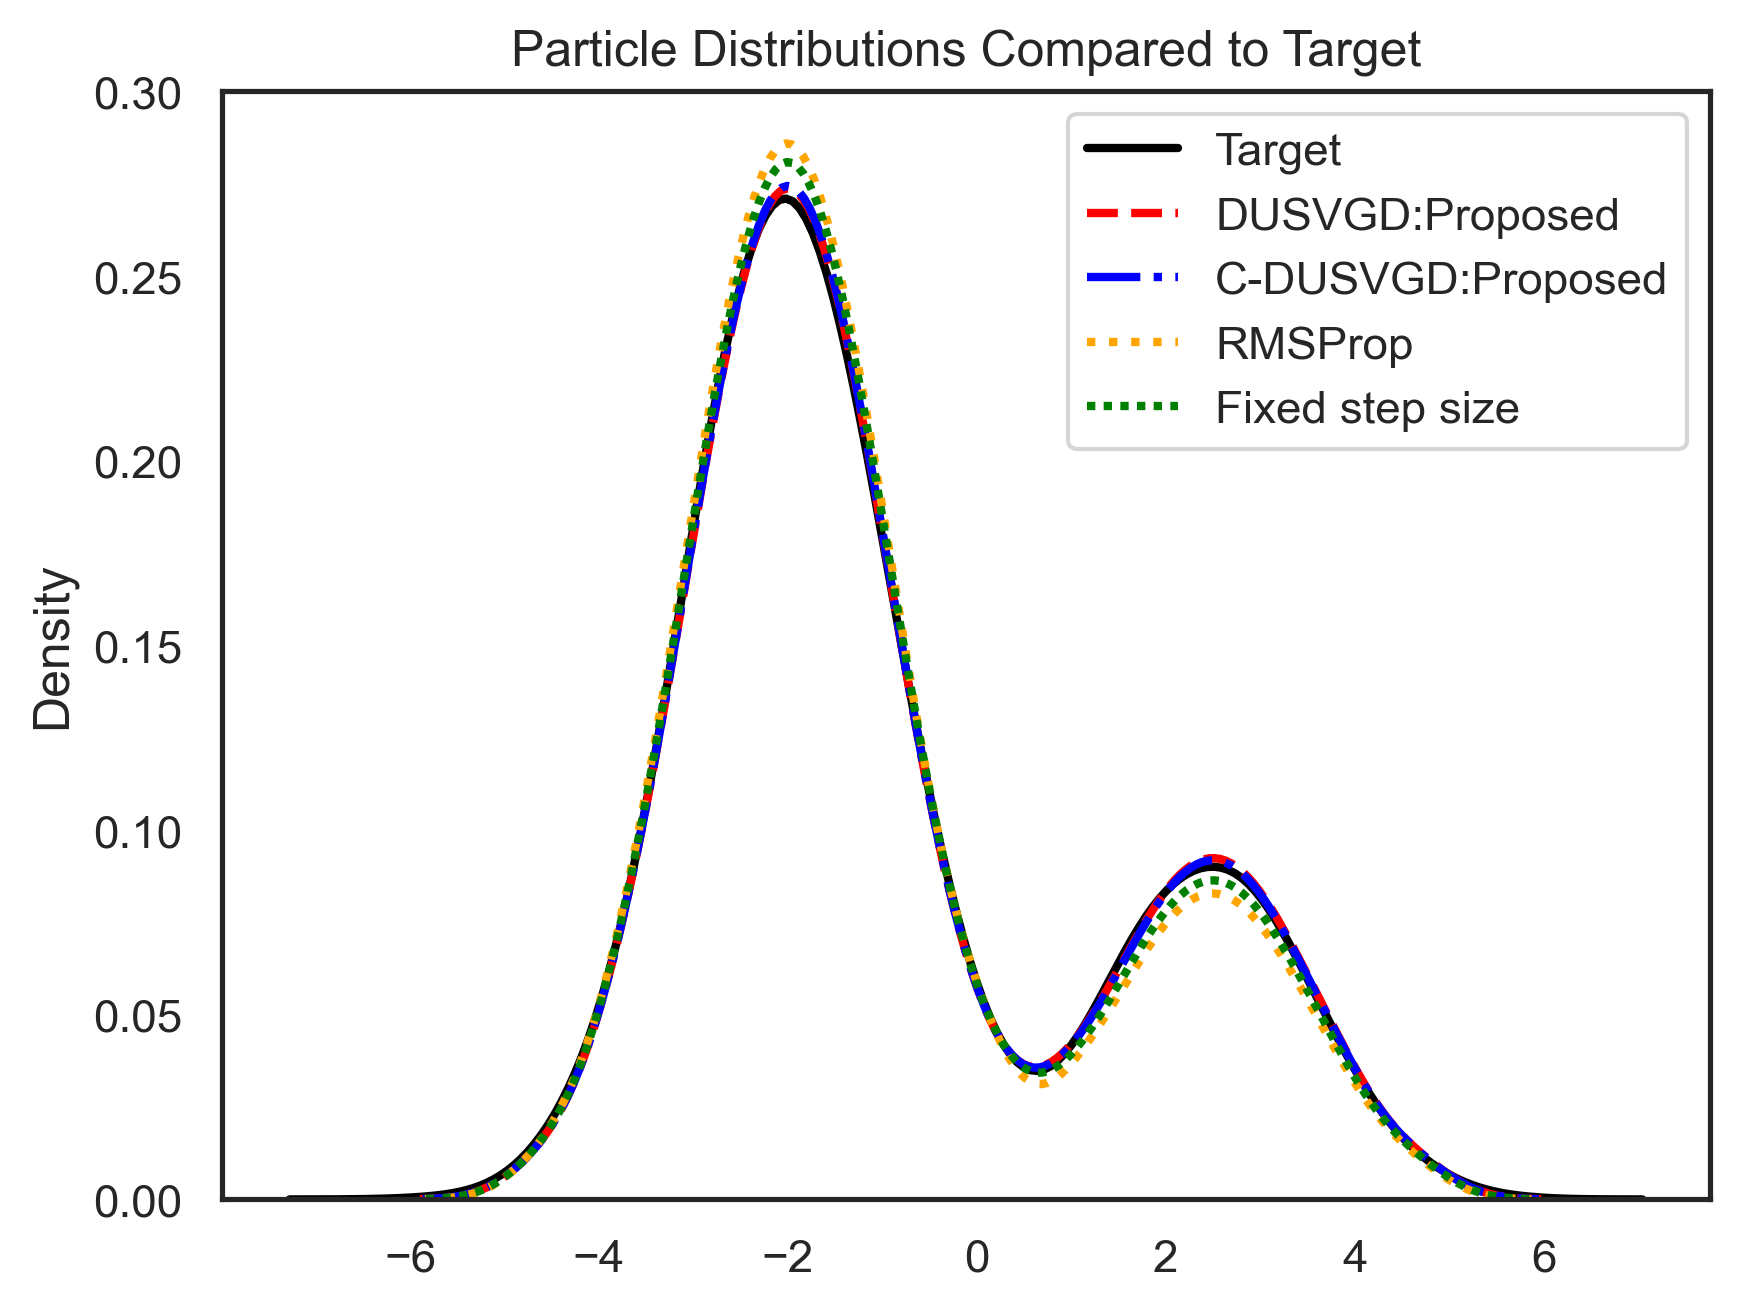

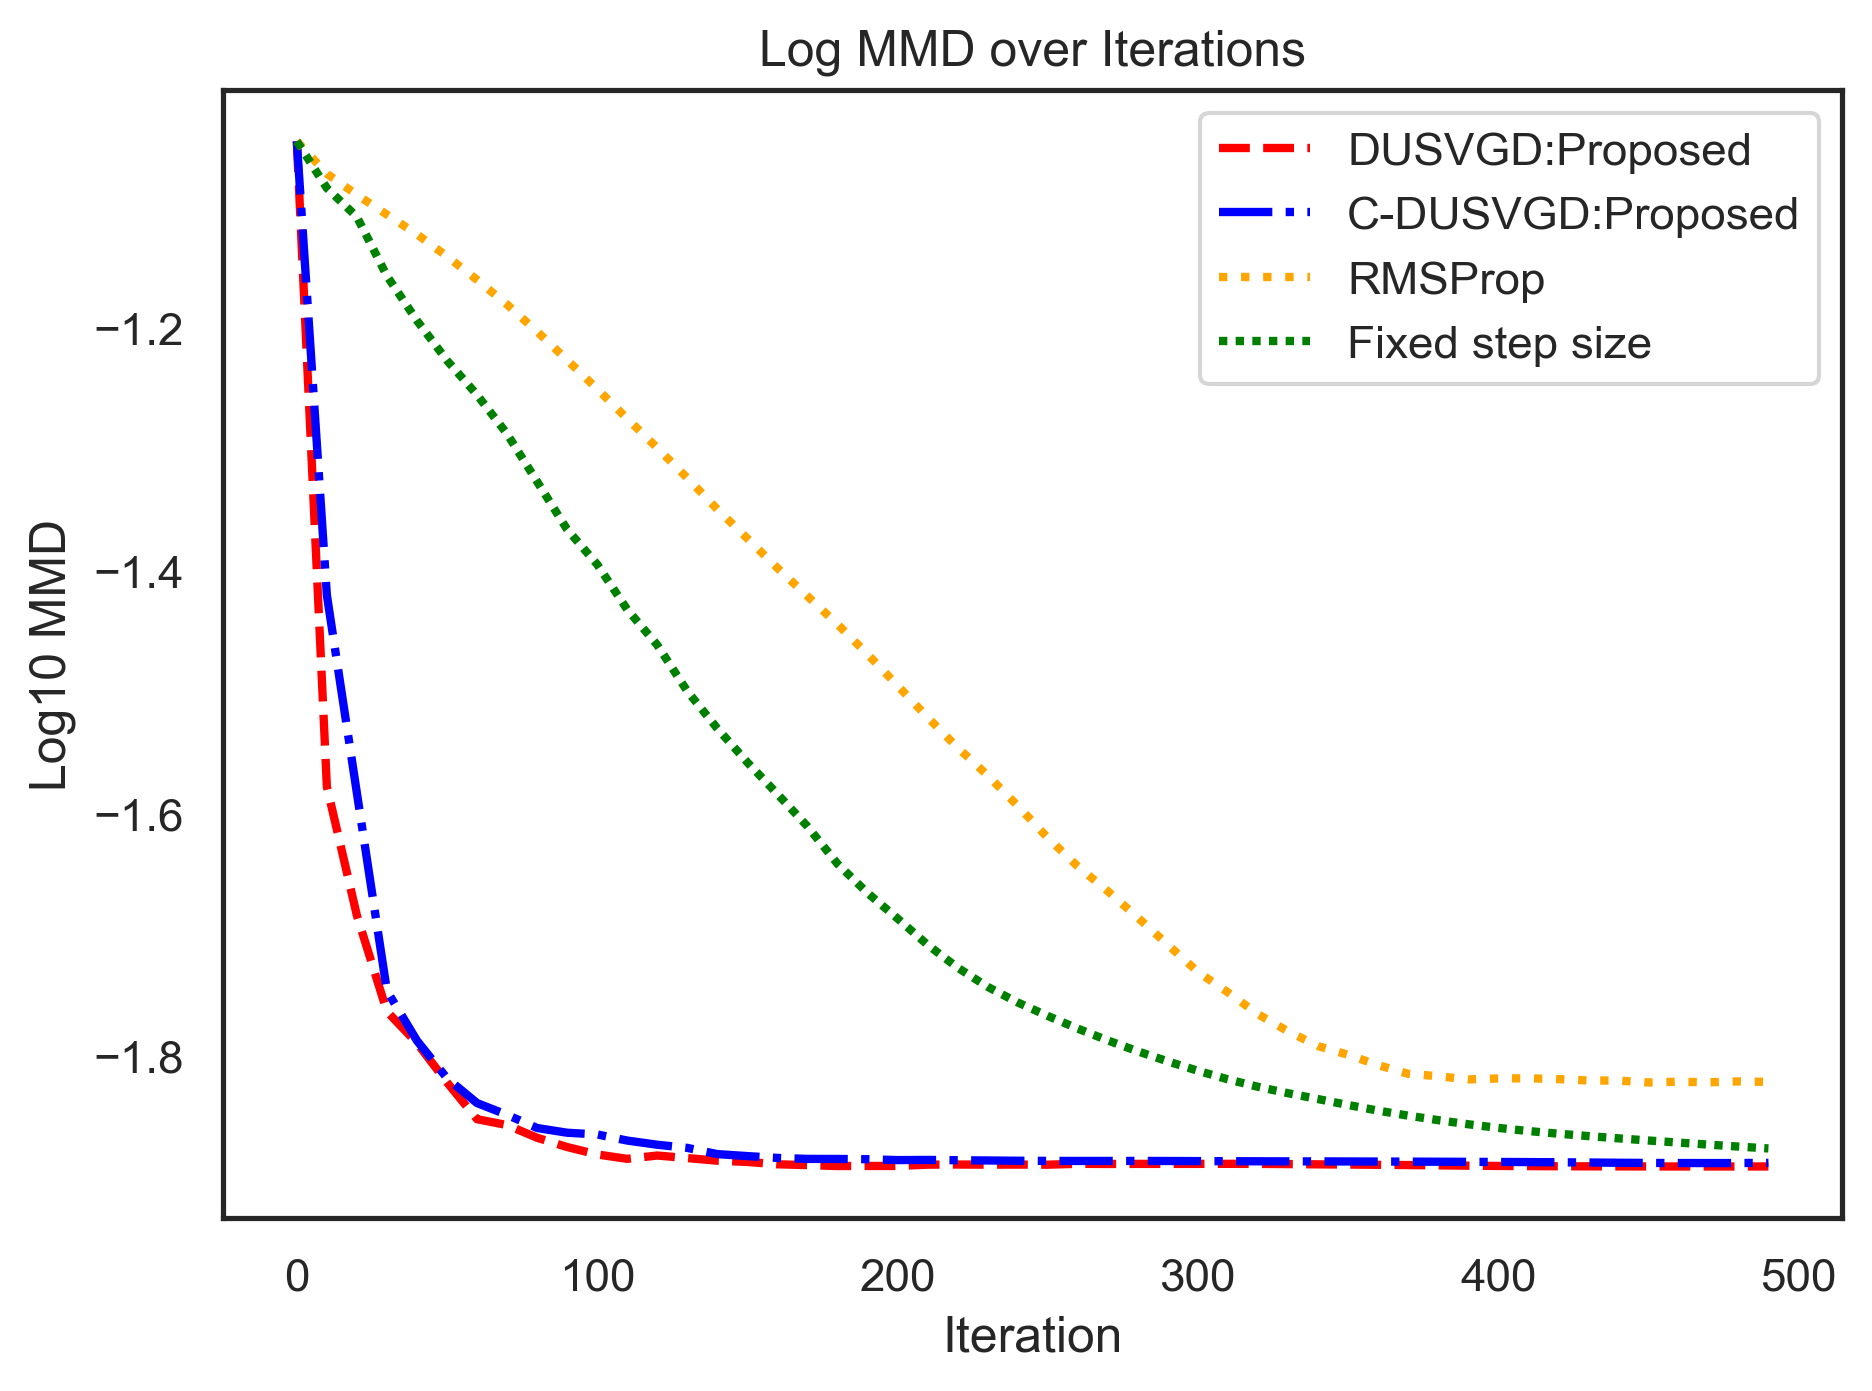

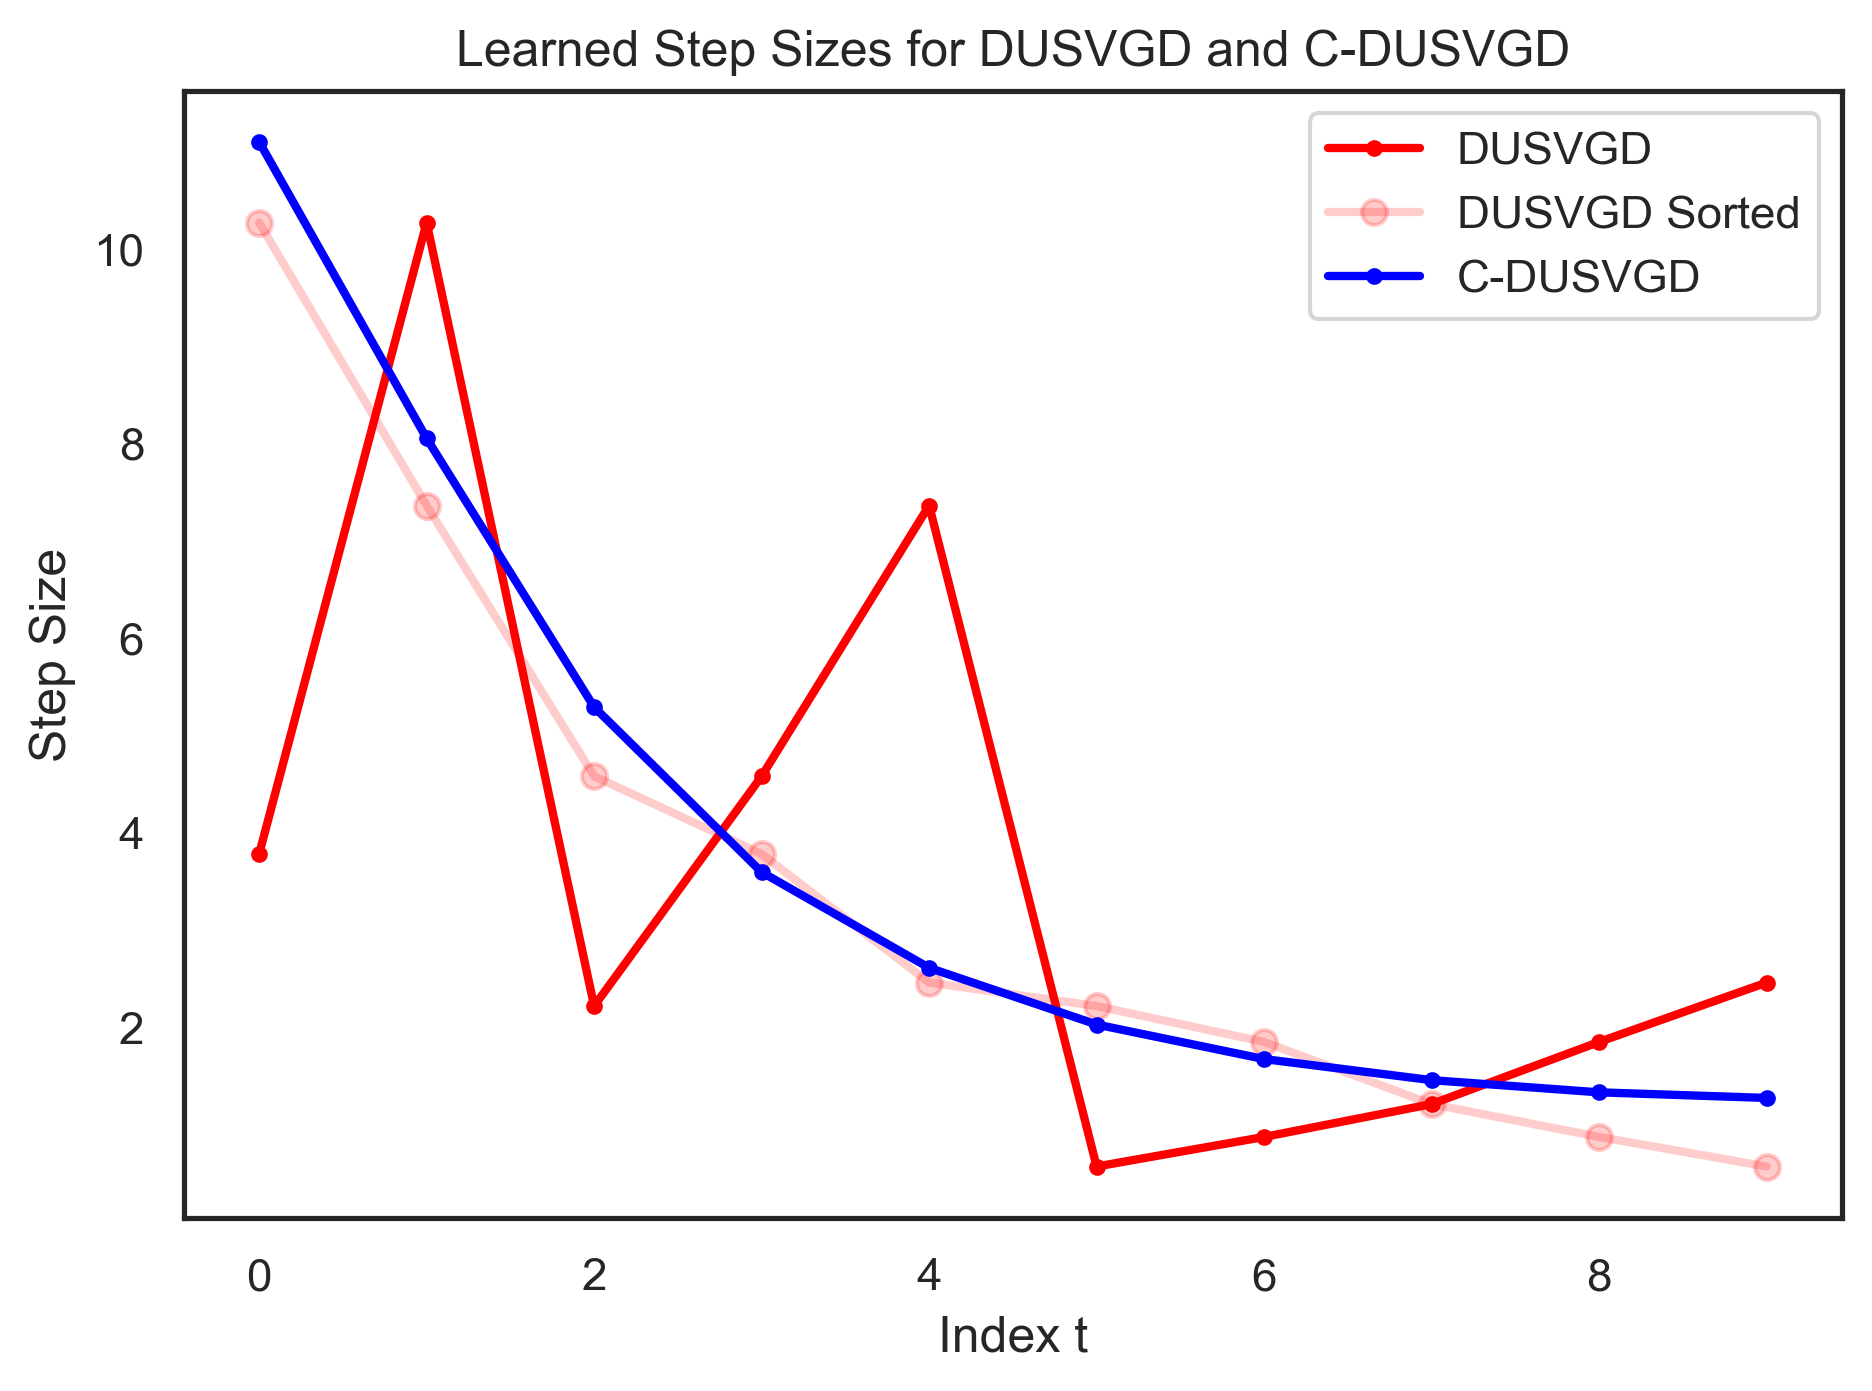

In [14]:
# Print hyperparameters to verify settings
print_hyperparameters()

# Plotting function for results
def plotf():
    particles = [p.detach().flatten().cpu().numpy() for p in particles_list]
    
    print("\nLearned Step Sizes:")
    print("DUSVGD:", lr_dugd)
    print("C-DUSVGD:", lr_cdugd)

    w, w2 = 2, 2 #linewidth

    plt.figure(dpi=300)
    target = target_model.sample([10000])
    sns.kdeplot(target.squeeze().detach().cpu().numpy(), linewidth=w2, bw_method=0.2, color="black", label="Target")
    
    styles = ["dashed", "dashdot", "dotted", (0, (1, 1))]
    colors = ["red", "blue", "orange", "green", "purple"]
    labels = ["DUSVGD:Proposed", "C-DUSVGD:Proposed", "RMSProp", "Fixed step size"]

    for i, (p, style, color, label) in enumerate(zip(particles, styles, colors, labels)):
        sns.kdeplot(p, linewidth=w, bw_method=0.2, linestyle=style, color=color, label=label)

    plt.legend()
    plt.title("Particle Distributions Compared to Target")
    plt.show()

    plt.figure(dpi=300)
    x_plt = np.arange(0, iteration_, max_du_iterations)
    for d in range(D):
        plt.plot(x_plt, np.log10(mmds[d]), linewidth=w, linestyle=styles[d], color=colors[d], label=labels[d])

    plt.xlabel("Iteration")
    plt.ylabel("Log10 MMD")
    plt.title("Log MMD over Iterations")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(dpi=300)
    plt_x = np.arange(0, max_du_iterations)
    plt_dugd_step = lr_dugd.detach().cpu().numpy()
    plt_cdugd_step = lr_c

    plt.plot(plt_x, plt_dugd_step, marker=".", color="red", linewidth=w, label="DUSVGD")
    plt.plot(plt_x, np.sort(plt_dugd_step)[::-1], marker="o", color="red", alpha=0.2, linewidth=w, label="DUSVGD Sorted")
    plt.plot(plt_x, plt_cdugd_step, marker=".", color="blue", linewidth=w, label="C-DUSVGD")
    
    plt.xlabel("Index t")
    plt.ylabel("Step Size")
    plt.title("Learned Step Sizes for DUSVGD and C-DUSVGD")
    plt.legend()
    plt.tight_layout()
    plt.show()

plotf()